In [11]:
import numpy as np
import torch

print("Torch version:", torch.__version__)

Torch version: 1.8.1


In [12]:
MODELS = {
    "ViT-B/32":       "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
}

In [13]:
# ! wget {MODELS["ViT-B/32"]} -O model.pt

In [14]:
model = torch.jit.load("model.pt").cuda().eval()
input_resolution = model.input_resolution.item()
context_length = model.context_length.item()
vocab_size = model.vocab_size.item()

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [15]:
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image

preprocess = Compose([
    Resize(256, interpolation=Image.BICUBIC),
    CenterCrop(input_resolution),
    ToTensor()
])

image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).cuda()
image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).cuda()

/om5/user/smadan/miniconda3/envs/diff_rendering_ml/lib/python3.8/site-packages/torchvision/transforms/transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [16]:
# ! pip install ftfy regex
# ! wget https://openaipublic.azureedge.net/clip/bpe_simple_vocab_16e6.txt.gz -O bpe_simple_vocab_16e6.txt.gz

In [17]:
#@title

import gzip
import html
import os
from functools import lru_cache

import ftfy
import regex as re


@lru_cache()
def bytes_to_unicode():
    """
    Returns list of utf-8 byte and a corresponding list of unicode strings.
    The reversible bpe codes work on unicode strings.
    This means you need a large # of unicode characters in your vocab if you want to avoid UNKs.
    When you're at something like a 10B token dataset you end up needing around 5K for decent coverage.
    This is a signficant percentage of your normal, say, 32K bpe vocab.
    To avoid that, we want lookup tables between utf-8 bytes and unicode strings.
    And avoids mapping to whitespace/control characters the bpe code barfs on.
    """
    bs = list(range(ord("!"), ord("~")+1))+list(range(ord("¡"), ord("¬")+1))+list(range(ord("®"), ord("ÿ")+1))
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8+n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))


def get_pairs(word):
    """Return set of symbol pairs in a word.
    Word is represented as tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs


def basic_clean(text):
    text = ftfy.fix_text(text)
    text = html.unescape(html.unescape(text))
    return text.strip()


def whitespace_clean(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text


class SimpleTokenizer(object):
    def __init__(self, bpe_path: str = "bpe_simple_vocab_16e6.txt.gz"):
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}
        merges = gzip.open(bpe_path).read().decode("utf-8").split('\n')
        merges = merges[1:49152-256-2+1]
        merges = [tuple(merge.split()) for merge in merges]
        vocab = list(bytes_to_unicode().values())
        vocab = vocab + [v+'</w>' for v in vocab]
        for merge in merges:
            vocab.append(''.join(merge))
        vocab.extend(['<|startoftext|>', '<|endoftext|>'])
        self.encoder = dict(zip(vocab, range(len(vocab))))
        self.decoder = {v: k for k, v in self.encoder.items()}
        self.bpe_ranks = dict(zip(merges, range(len(merges))))
        self.cache = {'<|startoftext|>': '<|startoftext|>', '<|endoftext|>': '<|endoftext|>'}
        self.pat = re.compile(r"""<\|startoftext\|>|<\|endoftext\|>|'s|'t|'re|'ve|'m|'ll|'d|[\p{L}]+|[\p{N}]|[^\s\p{L}\p{N}]+""", re.IGNORECASE)

    def bpe(self, token):
        if token in self.cache:
            return self.cache[token]
        word = tuple(token[:-1]) + ( token[-1] + '</w>',)
        pairs = get_pairs(word)

        if not pairs:
            return token+'</w>'

        while True:
            bigram = min(pairs, key = lambda pair: self.bpe_ranks.get(pair, float('inf')))
            if bigram not in self.bpe_ranks:
                break
            first, second = bigram
            new_word = []
            i = 0
            while i < len(word):
                try:
                    j = word.index(first, i)
                    new_word.extend(word[i:j])
                    i = j
                except:
                    new_word.extend(word[i:])
                    break

                if word[i] == first and i < len(word)-1 and word[i+1] == second:
                    new_word.append(first+second)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_word = tuple(new_word)
            word = new_word
            if len(word) == 1:
                break
            else:
                pairs = get_pairs(word)
        word = ' '.join(word)
        self.cache[token] = word
        return word

    def encode(self, text):
        bpe_tokens = []
        text = whitespace_clean(basic_clean(text)).lower()
        for token in re.findall(self.pat, text):
            token = ''.join(self.byte_encoder[b] for b in token.encode('utf-8'))
            bpe_tokens.extend(self.encoder[bpe_token] for bpe_token in self.bpe(token).split(' '))
        return bpe_tokens

    def decode(self, tokens):
        text = ''.join([self.decoder[token] for token in tokens])
        text = bytearray([self.byte_decoder[c] for c in text]).decode('utf-8', errors="replace").replace('</w>', ' ')
        return text


In [18]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
# descriptions = {
#     "page": "a page of text about segmentation",
#     "chelsea": "a facial photo of a tabby cat",
#     "astronaut": "a portrait of an astronaut with the American flag",
#     "rocket": "a rocket standing on a launchpad",
#     "motorcycle_right": "a red motorcycle standing in a garage",
#     "camera": "a person looking at a camera on a tripod",
#     "horse": "a black-and-white silhouette of a horse", 
#     "coffee": "a cup of coffee on a saucer"
# }

In [19]:

imagenet_path = '/om5/user/xboix/data/ImageNet/raw-data/validation/'

categories = ["%s/%s"%(imagenet_path, i) for i in os.listdir(imagenet_path)]

In [1291]:
i = 0
for cat in categories:
    if 'n02346627' in cat:
        category_num = i
    i += 1

In [1307]:
# category_num = 196

import random
# random_img = random.choice(os.listdir(categories[category_num]))
random_img = random.sample(os.listdir(categories[category_num]), 8)

category_name = categories[category_num].split('/')[-1]
print(category_name)
print(random_img)
# imagenet_file = "%s/%s"%(categories[category_num], random_img)
imagenet_files = ["%s/%s"%(categories[category_num], i) for i in random_img]

n02346627
['ILSVRC2012_val_00027802.JPEG', 'ILSVRC2012_val_00021587.JPEG', 'ILSVRC2012_val_00037361.JPEG', 'ILSVRC2012_val_00012414.JPEG', 'ILSVRC2012_val_00015985.JPEG', 'ILSVRC2012_val_00004986.JPEG', 'ILSVRC2012_val_00025333.JPEG', 'ILSVRC2012_val_00031706.JPEG']


In [1308]:
images = []

for filename in imagenet_files:
    image = preprocess(Image.open(filename).convert("RGB"))
    images.append(image)

In [1309]:
image_input = torch.tensor(np.stack(images)).cuda()
image_input -= image_mean[:, None, None]
image_input /= image_std[:, None, None]

In [1310]:
tokenizer = SimpleTokenizer()
sot_token = tokenizer.encoder['<|startoftext|>']
eot_token = tokenizer.encoder['<|endoftext|>']

In [1311]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()

In [1312]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = [[sot_token] + tokenizer.encode(desc) + [eot_token] for desc in text_descriptions]
text_input = torch.zeros(len(text_tokens), model.context_length, dtype=torch.long)

for i, tokens in enumerate(text_tokens):
    text_input[i, :len(tokens)] = torch.tensor(tokens)

text_input = text_input.cuda()
text_input.shape

with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

Files already downloaded and verified


In [1313]:
top_probs

tensor([[1.0000e+00, 1.0426e-17, 9.3014e-28, 4.9590e-31, 3.6209e-31],
        [8.0874e-01, 1.9126e-01, 9.3875e-09, 8.1012e-11, 3.1049e-13],
        [1.0000e+00, 1.1750e-23, 8.6966e-27, 6.8857e-28, 4.9731e-29],
        [1.0000e+00, 1.6841e-15, 2.1778e-21, 4.5885e-22, 4.1299e-22],
        [1.0000e+00, 4.7650e-12, 1.2570e-20, 1.3566e-22, 6.0241e-23],
        [1.0000e+00, 1.9952e-16, 3.5033e-24, 8.8400e-27, 3.4378e-31],
        [1.0000e+00, 6.3456e-21, 1.2623e-24, 1.6934e-25, 4.3614e-31],
        [1.0000e+00, 2.8851e-33, 1.4581e-36, 1.2738e-36, 1.2244e-37]])

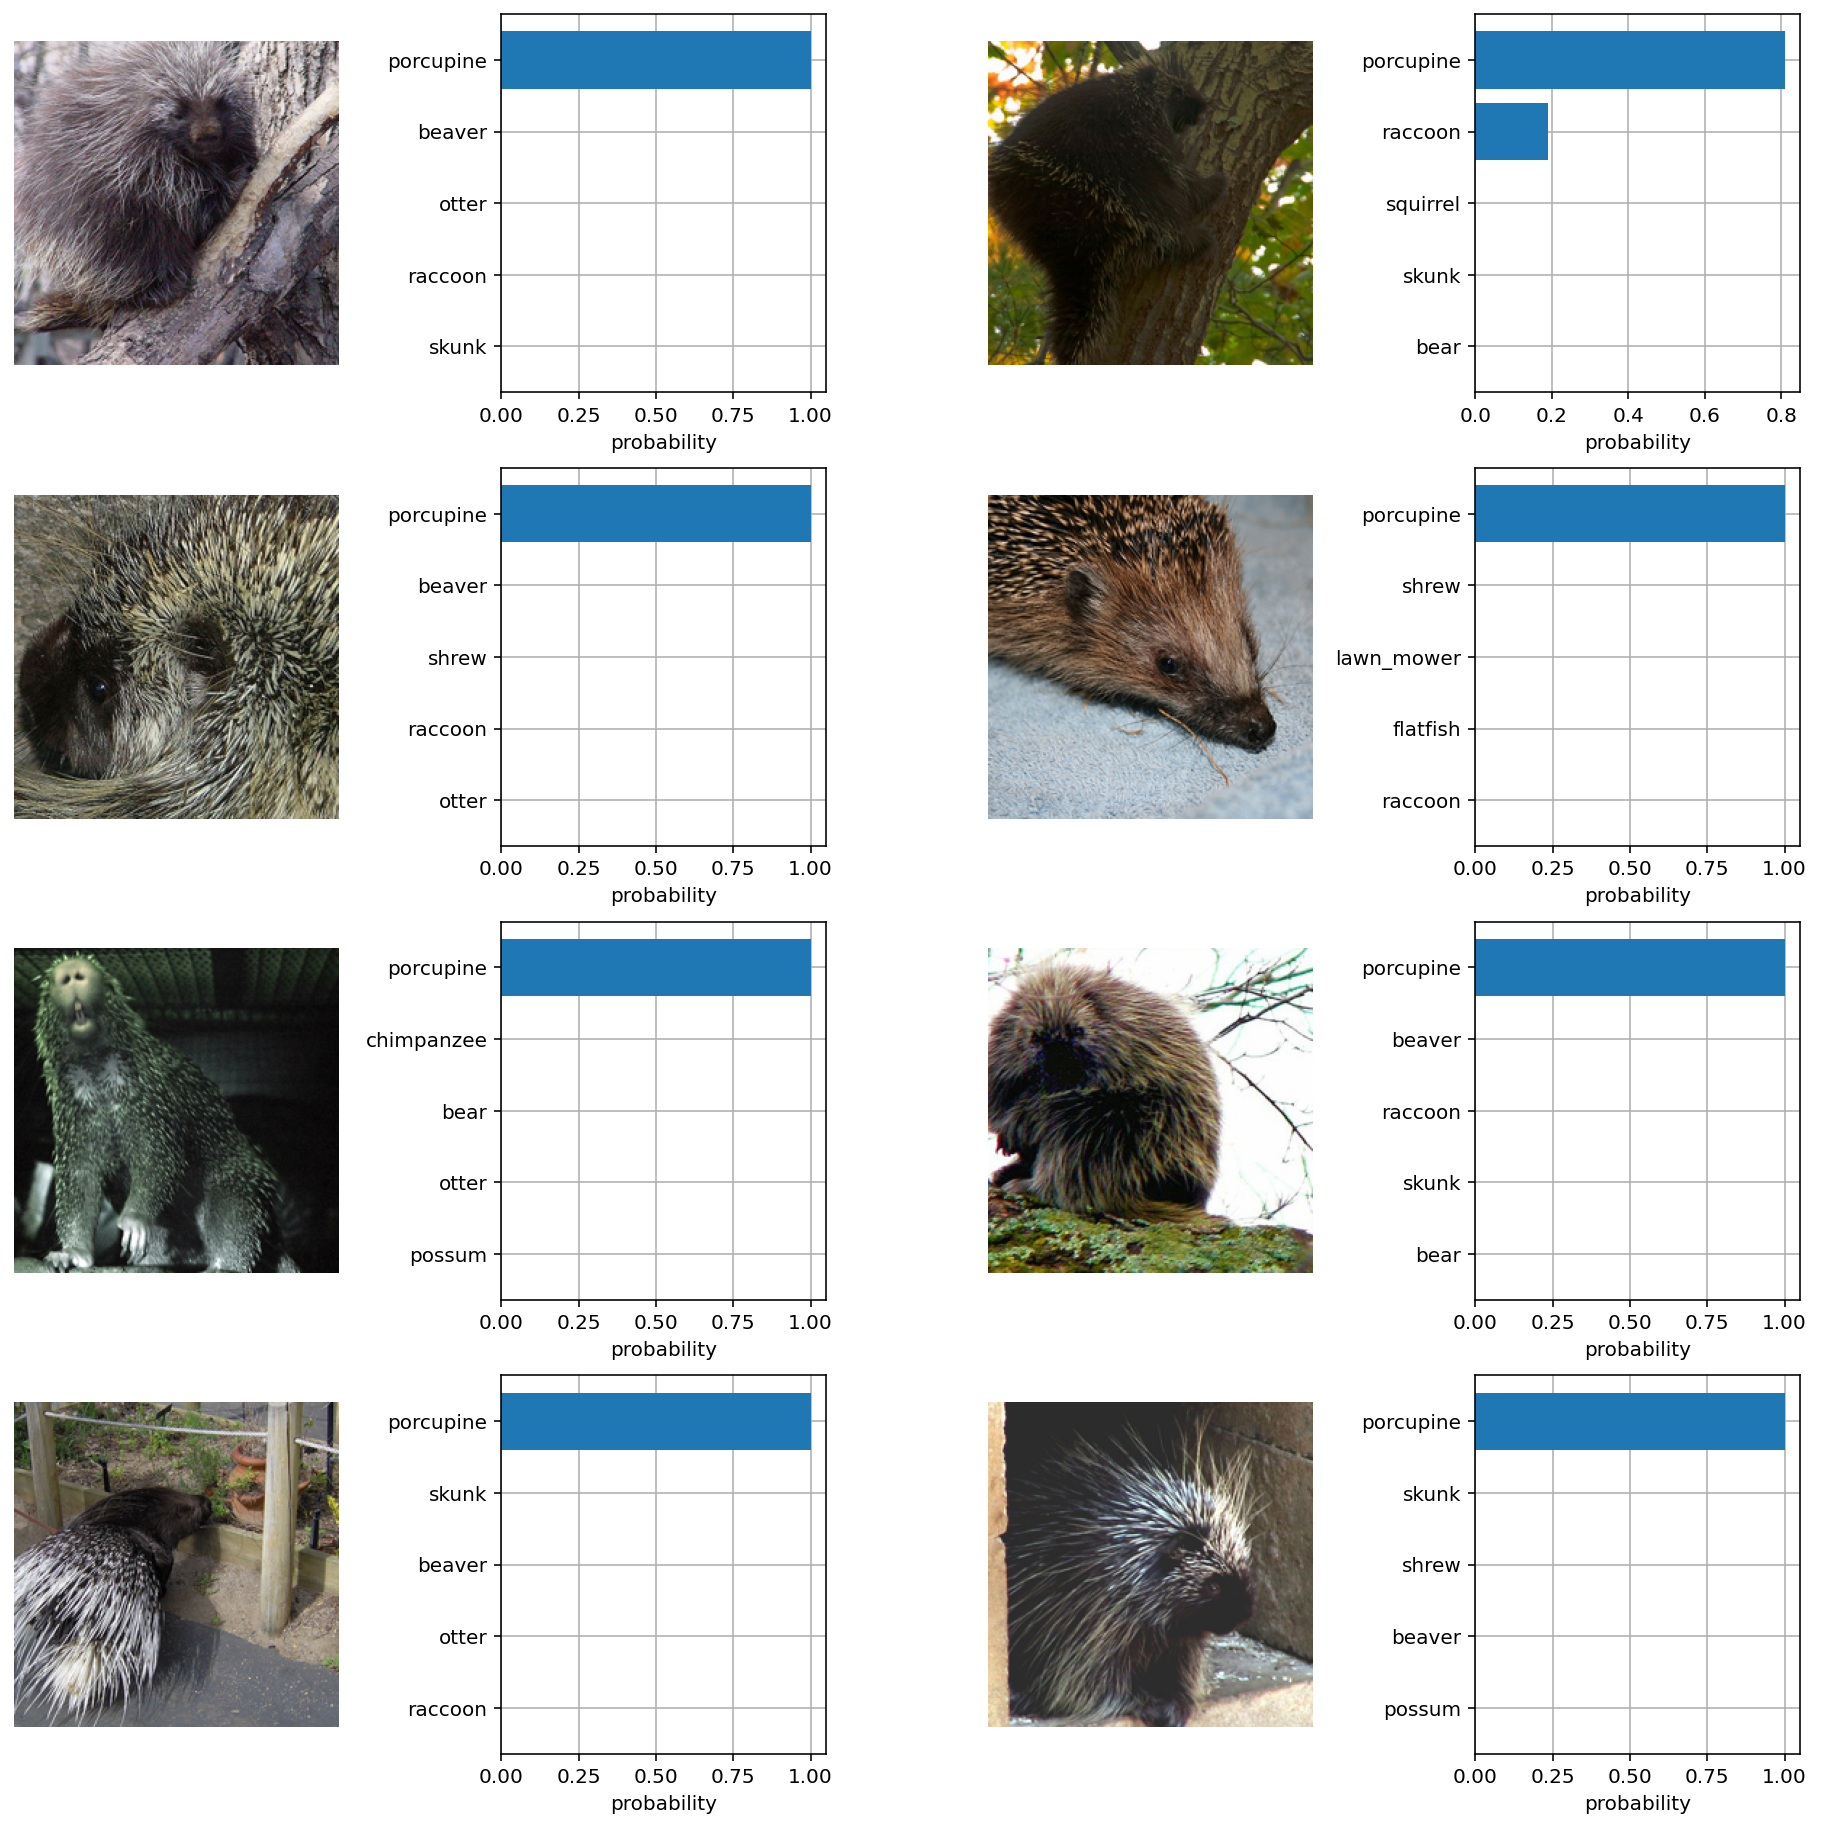

In [1314]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

In [1319]:
IM_NUM = 1

In [1320]:
# cma.CMAOptions('tol')

In [1321]:
def predict_img(img):
    image = preprocess(img.convert("RGB"))
    image_input = torch.tensor(image).unsqueeze(0).cuda()
    image_input -= image_mean[:, None, None]
    image_input /= image_std[:, None, None]
    with torch.no_grad():
        image_features = model.encode_image(image_input).float()
    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)
    return top_probs[0][0].item(), top_labels[0][0].item()

In [1322]:
pred_prob, pred_cat = predict_img(Image.open(imagenet_files[IM_NUM]))
print('Prediction: %s'%cifar100.classes[pred_cat])

Prediction: porcupine


<ipython-input-1321-79b94946b48a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_input = torch.tensor(image).unsqueeze(0).cuda()


In [1323]:
pred_prob

0.8087337017059326

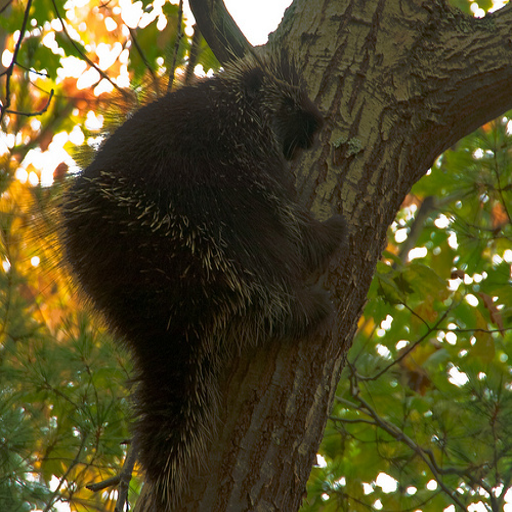

In [1324]:
Image.open(imagenet_files[IM_NUM]).resize((512,512))

In [1325]:
gt_percent, gt_cat = pred_prob, pred_cat

In [1326]:
# gt_percent

# MPI

In [1327]:
from tensorflow_addons import image as tfa_image
import numpy as np

import tensorflow as tf

from single_view_mpi.libs import mpi
from single_view_mpi.libs import nets
# from libs import mpi
# from libs import nets
input = tf.keras.Input(shape=(None, None, 3))
output = nets.mpi_from_image(input)

model_mpi = tf.keras.Model(inputs=input, outputs=output)
print('Model created.')
# Our full model, trained on RealEstate10K.
model_mpi.load_weights('single_view_mpi/single_view_mpi_full_keras/single_view_mpi_keras_weights')
print('Weights loaded.')

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)

Model created.
Weights loaded.


In [1328]:
import torch
import torchvision
from torchvision import models
from PIL import Image
import pyheif
import os
import matplotlib.pyplot as plt

from torchvision import transforms

In [1329]:
chosen_image = imagenet_files[IM_NUM]

In [1330]:
im = Image.open(chosen_image)

In [1331]:
temp_im = im.resize((512, 512))

In [1332]:
inputfile = "single_view_mpi/temp_image.png"

temp_im.save(inputfile)

# Generate MPI

input_rgb = tf.image.decode_image(tf.io.read_file(inputfile), dtype=tf.float32)
layers = model_mpi(input_rgb[tf.newaxis])[0]
depths = mpi.make_depths(1.0, 100.0, 32).numpy()

In [1333]:
# Rendering Code

reference_pose = tf.constant(
    [[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0]])
intrinsics = tf.constant([1.0, 1.0 * 16/9, 0.5, 0.5])

def render(xoffset, yoffset, zoffset):
  # The translation is the final column of the pose matrix
    target_pose = tf.constant(
    [[1.0, 0.0, 0.0, -xoffset],
     [0.0, 1.0, 0.0, -yoffset],
     [0.0, 0.0, 1.0, -zoffset]])
    image = mpi.render(layers, depths,
                     reference_pose, intrinsics,  # Reference view
                     target_pose, intrinsics,  # Target view
                     height=512, width=512)
    return image

In [1334]:
def objective(offsets, show = False):
    rendered_img = render(offsets[0], offsets[1], offsets[2])
#     rendered_img = render(offsets[0], 0, offsets[1])
    rendered_pil = Image.fromarray((np.array(rendered_img)*255).astype('uint8'))
    percent, pred_id = predict_img(rendered_pil)
    if show == True:
        plt.figure(figsize=(5, 5))
        plt.imshow(rendered_pil.resize((256,256)).crop((16,16,240,240)))
        plt.axis('off')
        plt.title('Pred: %s (%s)'%(cifar100.classes[pred_id], pred_id))
    return percent, pred_id

# GT Image

<ipython-input-1321-79b94946b48a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_input = torch.tensor(image).unsqueeze(0).cuda()


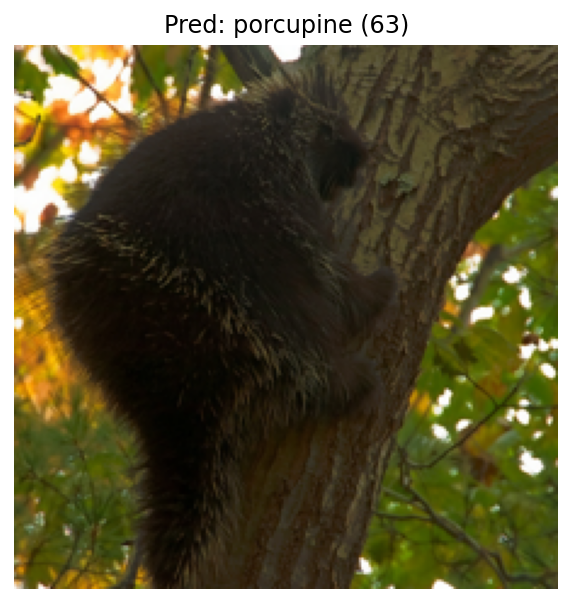

In [1335]:
gt_percent, gt_cat = objective([0.0,0.0,0.0], True)

In [1336]:
gt_percent

0.6858952641487122

In [1337]:
cifar100.classes[gt_cat]

'porcupine'

# CMA attack

In [1338]:
import cma

In [1339]:
# es = cma.CMAEvolutionStrategy(start_pos, 0.025)

In [1340]:
# import imp

In [1341]:
# imp.reload(cma)

In [1342]:
import cma 
start_pos = np.array([0, 0, 0])
es = cma.CMAEvolutionStrategy(start_pos, 0.025)
# es.opts['tolfun'] = 1e-200
es.optimize(objective, verb_disp = True, iterations=10, correct_prediction = gt_cat)

(3_w,7)-aCMA-ES (mu_w=2.3,w_1=58%) in dimension 3 (seed=682002, Tue Jun  1 17:15:55 2021)


<ipython-input-1321-79b94946b48a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_input = torch.tensor(image).unsqueeze(0).cuda()


Adversarial found, should stop now.
Adversarial found, should stop now.
Adversarial found, should stop now.
Adversarial found, should stop now.
Adversarial found, should stop now.
Predictions are :[63, 63, 66, 66, 66, 66, 66]
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      7 6.766132116317749e-01 1.0e+00 2.42e-02  2e-02  3e-02 0:03.5
Adversarial found, trying to stop.
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      7 6.766132116317749e-01 1.0e+00 2.42e-02  2e-02  3e-02 0:03.5
termination by {}
best f-value = 0.6766132116317749
solution = [-0.02253647 -0.0085738  -0.03609486]


<ipython-input-1321-79b94946b48a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_input = torch.tensor(image).unsqueeze(0).cuda()


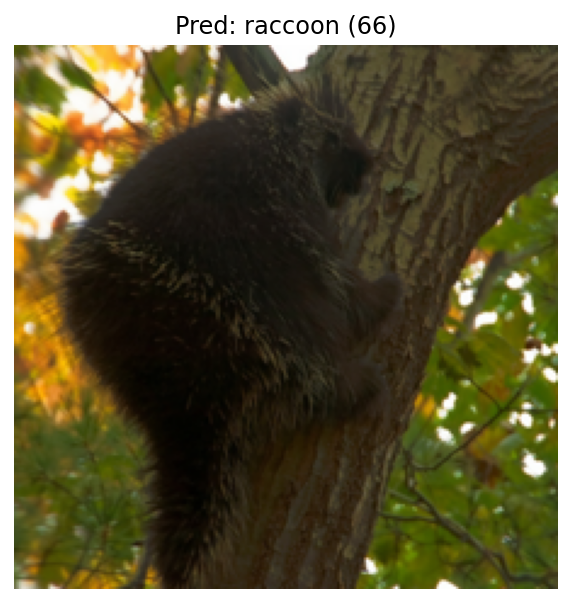

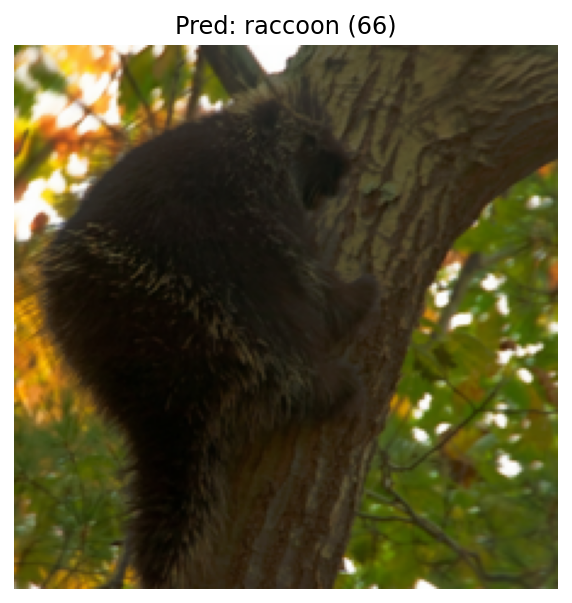

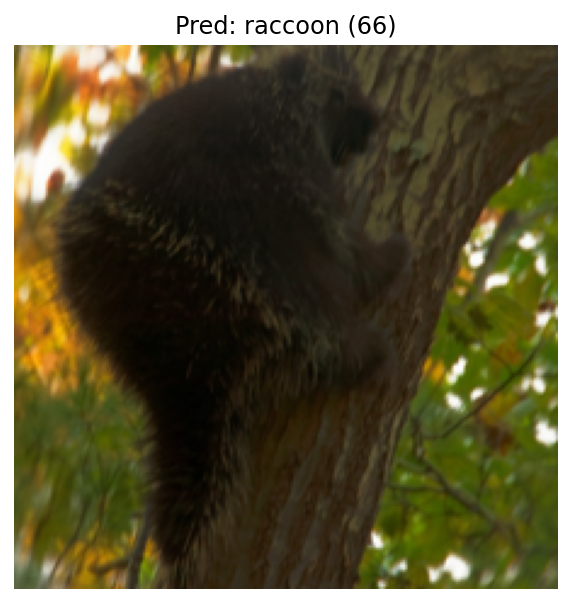

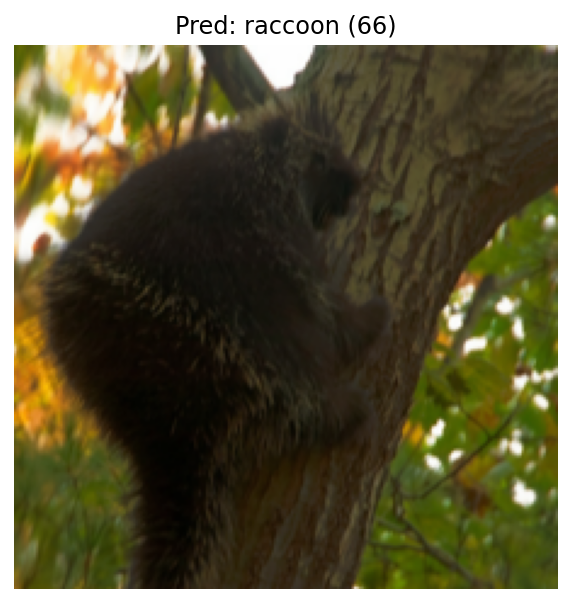

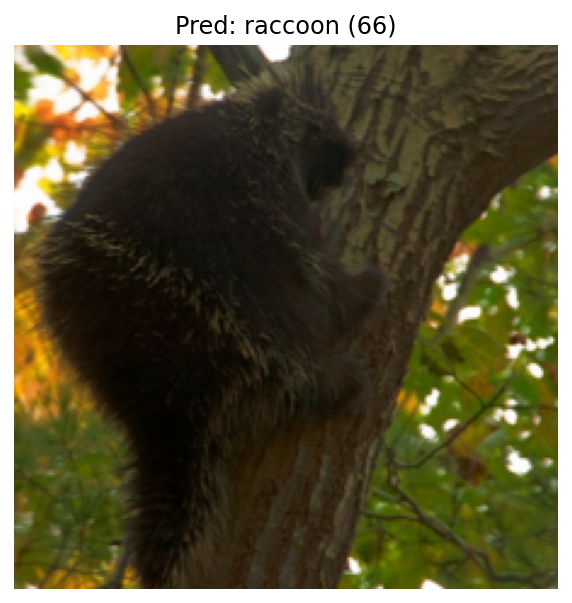

In [1343]:
errored_indexes = [i for i in range(len(es.predictions)) if es.predictions[i] != gt_cat]
errored_settings = [es.prediction_settings[i] for i in errored_indexes]
for er in errored_settings:
    objective(er, True)